# Teste Simples do Itaú

In [1]:
# Imports
import pandas as pd
from dowhy import CausalModel
import networkx as nx
import numpy as np

/home/lawand/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
n = 1000

# Step 1: Generate exogenous variables U and E

# U is an exogenous binary variable (e.g., representing an unobserved confounder)
# We can assume P(U=1) = 0.5
p_U = 0.5
U = np.random.choice([0, 1], size=n, p=[1 - p_U, p_U])

# E is another exogenous binary variable
# We can assume P(E=1) = 0.5
p_E = 0.5
E = np.random.choice([0, 1], size=n, p=[1 - p_E, p_E])

# Step 2: Generate T given U
# T depends on U: U -> T
# Define P(T=1 | U)
P_T_given_U = {
    0: 0.3,  # P(T=1 | U=0)
    1: 0.7   # P(T=1 | U=1)
}

T = np.zeros(n, dtype=int)
for i in range(n):
    U_i = U[i]
    p_T = P_T_given_U[U_i]
    T[i] = np.random.choice([0, 1], p=[1 - p_T, p_T])

# Step 3: Generate D given T and E
# D depends on T and E: T -> D, E -> D
# Define P(D=1 | T, E)
P_D_given_T_E = {
    (0, 0): 0.1,  # P(D=1 | T=0, E=0)
    (0, 1): 0.4,  # P(D=1 | T=0, E=1)
    (1, 0): 0.6,  # P(D=1 | T=1, E=0)
    (1, 1): 0.9   # P(D=1 | T=1, E=1)
}

D = np.zeros(n, dtype=int)
for i in range(n):
    T_i = T[i]
    E_i = E[i]
    p_D = P_D_given_T_E[(T_i, E_i)]
    D[i] = np.random.choice([0, 1], p=[1 - p_D, p_D])

# Step 4: Generate Y given T, U, and D
# Y depends on T, U, and D: T -> Y, U -> Y, D -> Y
# Define P(Y=1 | T, U, D)
P_Y_given_T_U_D = {
    (0, 0, 0): 0.1,  # P(Y=1 | T=0, U=0, D=0)
    (0, 0, 1): 0.3,  # P(Y=1 | T=0, U=0, D=1)
    (0, 1, 0): 0.2,  # P(Y=1 | T=0, U=1, D=0)
    (0, 1, 1): 0.4,  # P(Y=1 | T=0, U=1, D=1)
    (1, 0, 0): 0.5,  # P(Y=1 | T=1, U=0, D=0)
    (1, 0, 1): 0.7,  # P(Y=1 | T=1, U=0, D=1)
    (1, 1, 0): 0.6,  # P(Y=1 | T=1, U=1, D=0)
    (1, 1, 1): 0.8   # P(Y=1 | T=1, U=1, D=1)
}

Y = np.zeros(n, dtype=int)
for i in range(n):
    T_i = T[i]
    U_i = U[i]
    D_i = D[i]
    p_Y = P_Y_given_T_U_D[(T_i, U_i, D_i)]
    Y[i] = np.random.choice([0, 1], p=[1 - p_Y, p_Y])

# Create a DataFrame to store the generated data
labels = []

data = pd.DataFrame({
    'E': E,
    'T': T,
    'D': D,
    'Y': Y,
    'U': U
})
data.to_csv("itau_teste.csv", index=False)
print(data.head())
unob_data = data.drop(columns=['U'])
unob_data.to_csv("unob_itau_teste.csv", index=False)
print(unob_data.head())

   E  T  D  Y  U
0  0  0  0  0  0
1  1  0  1  1  1
2  1  1  1  1  1
3  1  0  1  0  1
4  1  0  0  0  0
   E  T  D  Y
0  0  0  0  0
1  1  0  1  1
2  1  1  1  1
3  1  0  1  0
4  1  0  0  0


In [3]:
edges = "T -> Y, T -> D, U -> Y, U -> T, D -> Y, E -> D"
tuple_edges = [tuple(edge.split(' -> ')) for edge in edges.split(', ')]
DAG = nx.DiGraph(tuple_edges)

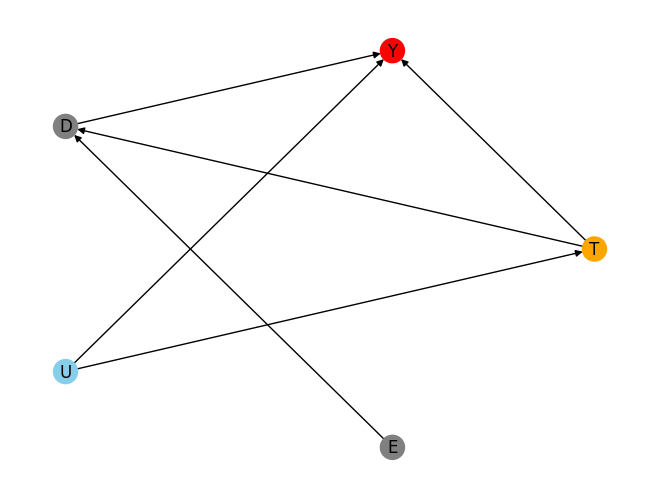

In [4]:
node_colors = []
for node in DAG.nodes:
    if node == 'Y':
        node_colors.append('red')
    elif node == 'T':
        node_colors.append('orange')
    elif node == 'U':
        node_colors.append('skyblue')
    else:
        node_colors.append('grey')
nx.draw(DAG, nx.circular_layout(DAG), with_labels=True, node_color=node_colors)

In [5]:
# Step 1: Model
model = CausalModel(
    data=data,
    treatment='T',
    outcome='Y',
    graph=DAG
)

## Identifying

In [6]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,U,U) = P(Y|T,U)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimation

In [7]:
# Step 3: Estimate
# Choose the second estimand: using IV
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting", 
                                 test_significance=True,
                                 confidence_intervals=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,U,U) = P(Y|T,U)

## Realized estimand
b: Y~T+U
Target units: ate

## Estimate
Mean value: 0.46773682204135414
p-value: [0, 0.001]
95.0% confidence interval: (0.40294429819759225, 0.5321673034383808)



## Refutation

In [8]:
# Step 4: Refute (Placebo Treatment)
ref = model.refute_estimate(identified_estimand, 
                            estimate, 
                            method_name="placebo_treatment_refuter", 
                            placebo_type="permute") # only permute placebo_type works with IV estimate
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:0.46773682204135414
New effect:-0.11538564583141522
p value:0.0



In [9]:
# Step 4: Refute (Dummy Outcome)
ref = model.refute_estimate(identified_estimand, 
                            estimate, 
                            method_name="dummy_outcome_refuter") 
print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0013376792683574628
p value:0.98

